# Fine-tuned DistilBERT Model

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
#import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
! pip install datasets transformers seqeval
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=8a93683650ebb84cc7740986a0c00ba76dd6490a810e7f56b96b25320e99204a
  St

In [2]:
!pip install clean-text[gpl]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 18.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=01c759925b652e04019d8304649dc7bda21dab3041c6265c3c6317a33711aef5
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.12.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Creating pandas dataframe with the data
df=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MSDS_458_Code/MSDS_458_Assignment_4/cyberbullying_tweets.csv")

##Cleaning and Organizing Data

In [8]:
#looking at original data observation with emojis

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="",no_punct=True) #removing emojies and urls
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh why do they not make these for grownups,not_cyberbullying
1040,omg i have a feeling im going to be overwhelmed by my emoticons in tomorrows mkr,not_cyberbullying


In [12]:
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45502, 2)

In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7961
age                    7935
ethnicity              7922
other_cyberbullying    7707
gender                 7631
not_cyberbullying      6346
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

<ipython-input-14-baa905693e7d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)


In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7961
1    7935
3    7922
5    7707
2    7631
4    6346
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [17]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7086
1    7063
3    7052
5    6860
2    6792
4    5649
Name: label_values, dtype: int64

In [18]:
#making sure test set is stratified properly
y_test.value_counts()

0    875
1    872
3    870
5    847
2    839
4    697
Name: label_values, dtype: int64

In [19]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [20]:
#making sure train set is stratified properly
y_train.value_counts()

0    6211
1    6191
3    6181
5    6013
2    5954
4    4952
Name: label_values, dtype: int64

In [21]:
#making sure validation set is stratified properly
y_val.value_counts()

0    875
1    872
3    871
5    847
2    838
4    697
Name: label_values, dtype: int64

# DistilBERT Data Preprocessing and Tokenization

In [22]:
train=pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train.columns=["text","labels"]
validation=pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
validation.columns=["text","labels"]
test=pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test.columns=["text","labels"]

In [23]:
#Creating DatasetDict with combined train, validation and test test
final_dataset=DatasetDict(
            {"train":Dataset.from_pandas(train, split='train'),
             "validation":Dataset.from_pandas(validation, split='validation'),
             "test":Dataset.from_pandas(test, split='test')})

In [24]:
#defining distilbert checkpoint
model_checkpoint='distilbert-base-uncased'

#instantiating distilbert tokenizer
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint )

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

#encoding final dataset
final_dataset_encoded=final_dataset.map(tokenize,batched=True, batch_size=None)

Map:   0%|          | 0/35502 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [26]:
#instantiating data_collator which helps pad only the needed amount of tokens per batch as opposed to the max amount of tokens
#this saves on RAM used and helps avoid the "outo of RAM" error

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [27]:
#creating train, val, and test datasets compatible with tensorflow
tokenizer_columns = tokenizer.model_input_names
batch_size=16
train_dataset = final_dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["labels"], shuffle=True,
    batch_size=batch_size,collate_fn=data_collator,)
validation_dataset = final_dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["labels"], shuffle=False,
    batch_size=batch_size,collate_fn=data_collator,)
test_dataset = final_dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["labels"], shuffle=False,
    batch_size=batch_size,collate_fn=data_collator,)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


# Helpful Model Fitting and Results Functions

In [28]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [29]:

def compile_train_model(model, train, validation, model_num, epochs=100, patience=3, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()

    # Compile
    model.compile(optimizer=optimizer,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.metrics.SparseCategoricalAccuracy())

  # Train
    start_time = time.time()
    history = model.fit(
      train,
      epochs=epochs,
      batch_size=16,
      validation_data= validation,
      verbose=1,
      callbacks=[
          EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, restore_best_weights=True, verbose=0),
          #ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_2/best_saved_models/model_{}.h5'.format(model_num),
            #                   save_best_only=True,
             #                  save_weights_only=False,
              #                 monitor='val_loss')
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') #starts the average with the second epoch because the first one
                                                                        # usually takes a bit longer because the model is starting up


    return history, model

In [30]:
#Classificatin report function from starter code
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [41]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["sparse_categorical_accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_sparse_categorical_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["sparse_categorical_accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_sparse_categorical_accuracy"][-(1+patience)],4))

In [44]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["sparse_categorical_accuracy","val_sparse_categorical_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()

In [33]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set)[0].argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,

                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [34]:
keras.backend.clear_session()

# Experiment 8

In [35]:
#instantiating distilBERT model
num_labels=6
DistilBERT_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_checkpoint, num_labels=num_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [36]:
epochs=20
patience=3
model_number="8"
history_exp_8, model_exp_8 = compile_train_model(DistilBERT_model,
                                     train_dataset, validation_dataset, model_number, epochs,patience=patience,
                                    )

Epoch 1/20
2219/2219 [==============================] - 353s 146ms/step - loss: 0.3859 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.3075 - val_sparse_categorical_accuracy: 0.8894
Epoch 2/20
2219/2219 [==============================] - 271s 122ms/step - loss: 0.2278 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.8950
Epoch 3/20
2219/2219 [==============================] - 276s 124ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.3500 - val_sparse_categorical_accuracy: 0.8910
Epoch 4/20
2219/2219 [==============================] - 262s 118ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.4049 - val_sparse_categorical_accuracy: 0.8896
Epoch 5/20
2219/2219 [==============================] - 270s 122ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8904


Finished model training in 1527s
Average time to run each epoch is: 

In [37]:
model_exp_8.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0
_________________________________________________________________


In [42]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_8, model_number, epochs, patience=patience)

Model Experiment 8  Training Loss:  0.2278
Model Experiment 8  Training Accuracy:  0.9184
Model Experiment 8  Validation Loss:  0.3077
Model Experiment 8  Validation Accuracy: 0.895


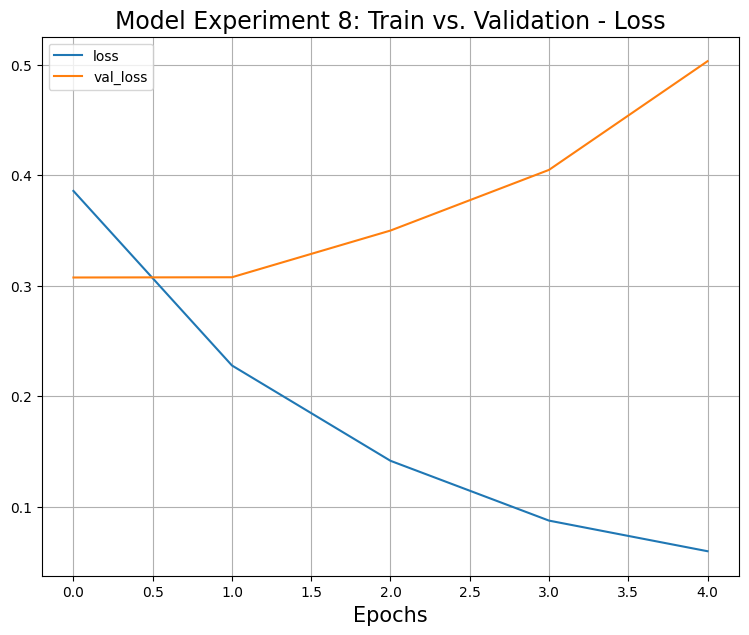

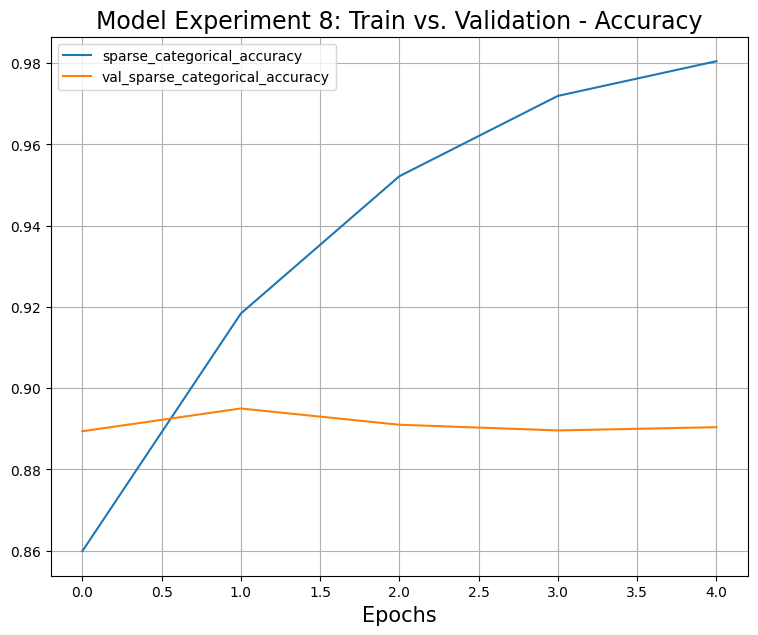

In [45]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_8, model_number)

In [46]:
#creating  classification report

#getting predictions

model_exp_8_predictions=model_exp_8.predict(test_dataset)[0].argmax(axis=1)
print_validation_report(y_test, model_exp_8_predictions)

313/313 [==============================] - 16s 45ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       875
           1       0.99      0.97      0.98       872
           2       0.92      0.86      0.89       839
           3       0.99      0.98      0.99       870
           4       0.74      0.69      0.71       697
           5       0.75      0.87      0.80       847

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.90      0.89      0.90      5000

Accuracy Score: 0.8944
Root Mean Square Error: 0.7718808198161164


313/313 [==============================] - 15s 48ms/step


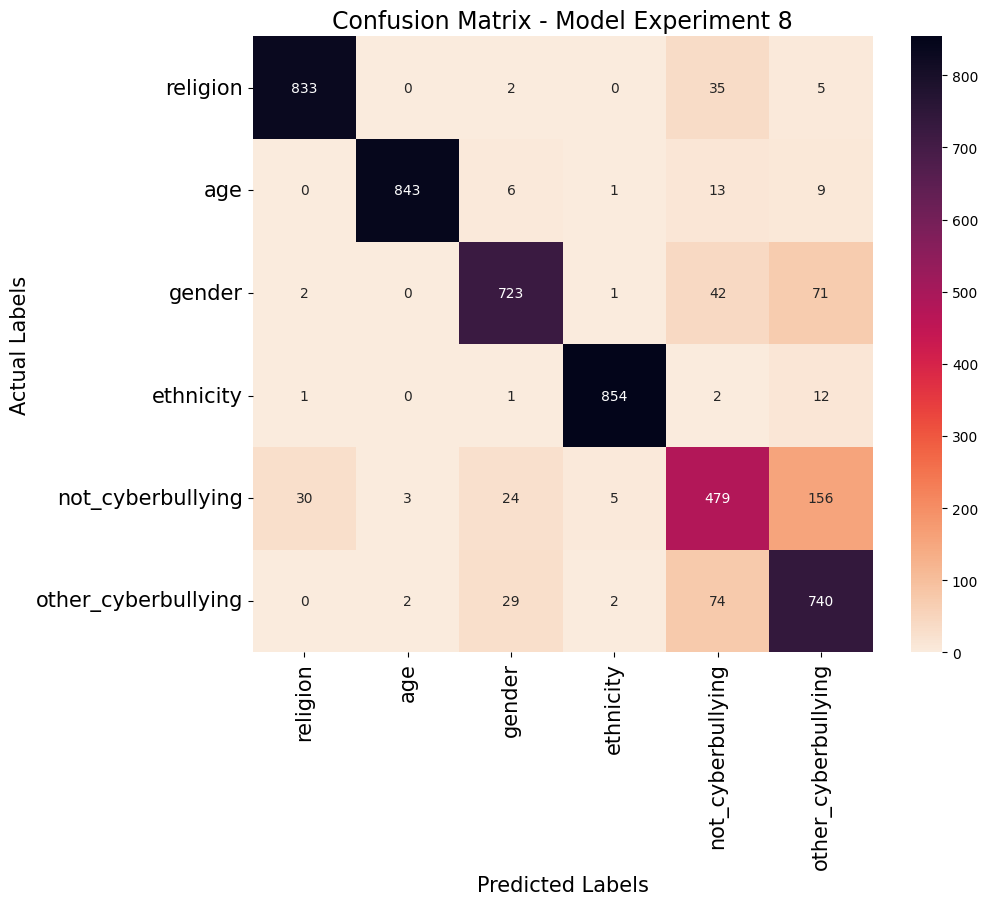

In [47]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_8, test_dataset,y_test, model_number)